In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.job_output import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from erank.mode_connectivity.instability_analysis import InstabilityAnalyzer

# DEBUG CIFAR 10 ResNet Pretraining

With this notebook I start the pretraining runs on CIFAR10, which are then used for later finetuning for the stability analysis. 
I also start the finetuning runs here

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [11,17,31]

sweep:
  type: grid
  axes: 
  - parameter: data.dataset_transforms.enable_transforms
    vals: [True, False]
  # - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
  #   vals: [0.1, 0.075, 0.05, 0.025]
  # - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
  #   vals: [0.0, 0.001, 0.005]
  # - parameter: trainer.batch_size
  #   vals: [64, 256, 512]
    
start_num: 1

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '13.1'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-B-pretrain
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-cifar10-B
    # name: resnet
    # model_kwargs:
    #   in_channels: 3
    #   act_fn: relu
    #   residual_option: B
    #   input_layer_config:
    #     kernel_size: 3
    #     out_channels: 16
    #     bias: false
    #     batch_norm: true
    #     stride: 1
    #     padding: 1
    #   resnet_blocks_config:
    #     - out_channels: 16
    #       num_residual_blocks: 3
    #     - out_channels: 32
    #       num_residual_blocks: 3
    #     - out_channels: 64
    #       num_residual_blocks: 3
    #   linear_output_units:
    #     - 10
    init_model: null

  trainer:
    training_setup: supervised
    n_steps: 64e3
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: true
    val_every: 500
    save_every: 1000
    early_stopping_patience: 64e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.01 #0.1
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [32e3, 48e3]
        gamma: 0.1

    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
    verbose: false
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      # restrict_n_samples_train_task: 100
    dataset_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: 
      joint_tensor_transforms: 
      enable_transforms: True
"""
cfg = OmegaConf.create(config_yaml)

In [3]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

### Sweep result

In [4]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 13.1(1)
Exp. Name: cifar10-13.1.1-resnet-B-pretrain
Training setup: supervised
Model name: resnet20-cifar10-B
Dataset name: cifar10
Sweep type: grid
  data.dataset_transforms.enable_transforms: [True, False]
Seeds: [11, 17, 31]
Num. jobs: 6
Config updated: 2023-01-12 16:36:01
Sweep started:  2023-01-12 16:39:14



In [5]:
failed_jobs = sweepr.get_failed_jobs()
failed_jobs # No failed jobs

([], {})

In [6]:
pprint(sweepr.available_log_columns)

{'_common_cols': ['epoch', 'train_step', 'log_step'],
 'train': ['loss_CrossEntropyLoss',
           'lr',
           'time_last_train_epoch_in_s',
           'Accuracy'],
 'train_step': ['loss_CrossEntropyLoss', 'weight_norm', 'Accuracy', 'lr'],
 'val': ['time_last_val_epoch_in_s', 'loss_CrossEntropyLoss', 'Accuracy']}


In [7]:
sw_summary = sweepr.get_summary()
sw_summary

,best_step,best_val_score,data.dataset_transforms.enable_transforms,seed
cifar10-13.1.1-resnet-B-pretrain--enable_transforms-0-seed-11--230112_172240,16000,0.7922,False,11
cifar10-13.1.1-resnet-B-pretrain--enable_transforms-0-seed-17--230112_163939,47500,0.7978,False,17
cifar10-13.1.1-resnet-B-pretrain--enable_transforms-0-seed-31--230112_163941,25500,0.7980,False,31
cifar10-13.1.1-resnet-B-pretrain--enable_transforms-1-seed-11--230112_163941,58500,0.8748,True,11
cifar10-13.1.1-resnet-B-pretrain--enable_transforms-1-seed-17--230112_172249,34500,0.8770,True,17
cifar10-13.1.1-resnet-B-pretrain--enable_transforms-1-seed-31--230112_163938,62000,0.8822,True,31


In [8]:
run = sweepr.get_jobs(searchstr='-1-seed-31')[0]
run

JobResult(cifar10-13.1.1-resnet-B-pretrain--enable_transforms-1-seed-31--230112_163938)

In [9]:
run.get_data_log('val')

,log_step,epoch,train_step,loss_CrossEntropyLoss,Accuracy,time_last_val_epoch_in_s
0,0,0,0,2.366093,0.0902,0.000000
1,501,2,500,1.409702,0.4854,2.906728
2,1003,3,1000,1.377557,0.5032,0.886624
3,1506,5,1500,1.260056,0.5514,0.880267
4,2008,6,2000,1.167949,0.5850,0.877970
...,...,...,...,...,...,...
124,62299,177,62000,0.437122,0.8822,0.526454
125,62801,178,62500,0.438947,0.8800,0.497475
126,63303,179,63000,0.446461,0.8808,0.511979
127,63806,181,63500,0.439624,0.8798,0.526959


In [10]:
model = run.get_model_idx(1000)
model.training

False

In [11]:
from erank.data.datasetgenerator import DatasetGenerator
from ml_utilities.torch_utils.metrics import TAccuracy
from torch.utils import data
import torchmetrics
from ml_utilities.data_utils import show_images

In [12]:
dsgen = DatasetGenerator(**cfg.config.data)
dsgen.generate_dataset()

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


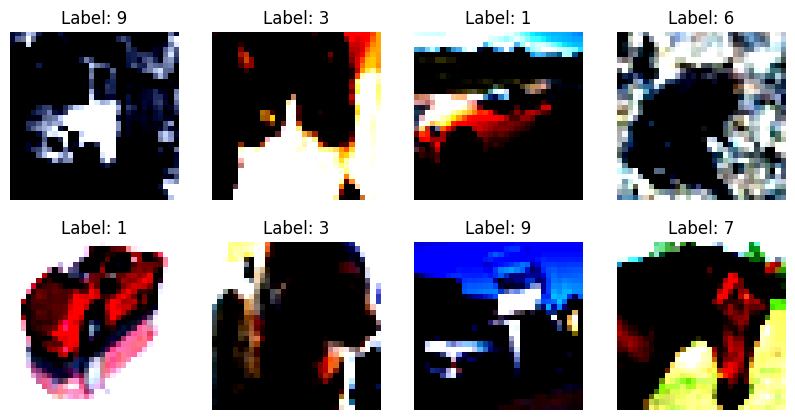

In [13]:
show_images(dsgen.val_split, 8, shuffle=False)

In [14]:
val_loader = data.DataLoader(dsgen.val_split, batch_size=128)

In [15]:
def eval_loop(model, dataloader, score_fn, device) -> float:
    batch_scores = []
    for batch_idx, (xs, ys) in enumerate(dataloader):
        xs, ys = xs.to(device), ys.to(device)
        with torch.no_grad():
            y_pred = model(xs)
            score = score_fn(y_pred, ys)
            batch_scores.append(score)
    return torch.tensor(batch_scores).mean().item()

In [16]:
eval_loop(model, val_loader, torchmetrics.Accuracy().to(torch.device('cuda:0')), torch.device('cuda:0'))

0.500195324420929

In [17]:
0.871874988079071
0.8724609613418579

0.8724609613418579